<a href="https://colab.research.google.com/github/aaravnoronha/SportsAnalyticsPolygence/blob/main/Scraping_NBA_Data.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

## Installs and Imports

In [1]:
!pip install beautifulsoup4 requests pandas tqdm

In [2]:
import requests
from bs4 import BeautifulSoup
import pandas as pd
import os
from tqdm import tqdm
import matplotlib.pyplot as plt
import seaborn as sns

In [3]:
## TODO Aarav: Scrape GSW box scores URLs from last 5 seasons
## TODO Aarav: Write a function that uses beautiful soup to determine if GSW won or not

def get_url_and_win_outcome(season_url):
  page = requests.get(season_url)
  soup = BeautifulSoup(page.content, 'html.parser')
  rows = soup.find("tbody").find_all("tr")
  list_games = []
  outcomes = []
  for row in rows:
    cells = row.find_all("td")
    if len(cells)>0:
      box = cells[3].find("a")["href"]
      list_games.append(box)
      outcomes.append(cells[6].get_text())
  return list_games, outcomes

games, outcomes = [], []
season_urls = ["https://www.basketball-reference.com/teams/GSW/2021_games.html",
               "https://www.basketball-reference.com/teams/GSW/2020_games.html",
               "https://www.basketball-reference.com/teams/GSW/2019_games.html",
               "https://www.basketball-reference.com/teams/GSW/2018_games.html",
               "https://www.basketball-reference.com/teams/GSW/2017_games.html"]
for url in season_urls:
  g, o = get_url_and_win_outcome(url)
  games.extend(g)
  outcomes.extend(o)
print(len(games), len(outcomes))

385 385


In [4]:
# get 3 letter abbreviations
def get_opp_abbr(soup):
  team_labels = soup.find(class_="scorebox").find_all("strong")
  for team_label in team_labels:
    team_url = str(team_label.find("a")["href"])
    end_idx = team_url.find("/20")
    abbr = team_url[end_idx-3:end_idx]
    if abbr != "GSW":
      opp_abbr = abbr
  return opp_abbr

In [5]:
def get_col_names(url):
  page = requests.get(url)
  soup = BeautifulSoup(page.content, 'html.parser')
  table = soup.find(class_="sortable stats_table", id="box-GSW-game-advanced")
  head = table.find(class_="thead").find_all("th")
  full_col_names = [x["aria-label"] for x in head][1:-1]
  col_names = [x.text for x in head][1:-1]
  return col_names, full_col_names

col_names, full_col_names = get_col_names("https://www.basketball-reference.com/boxscores/202012220BRK.html")
print(col_names)

['MP', 'TS%', 'eFG%', '3PAr', 'FTr', 'ORB%', 'DRB%', 'TRB%', 'AST%', 'STL%', 'BLK%', 'TOV%', 'USG%', 'ORtg', 'DRtg']


In [6]:
# scrape one box score page
def scrape_box_score_data(url="https://www.basketball-reference.com/boxscores/202012220BRK.html"):
  page = requests.get(url)
  soup = BeautifulSoup(page.content, 'html.parser')
  try:
    data = []
    for abbr in ['GSW', get_opp_abbr(soup)]:
      table = soup.find(class_="sortable stats_table", id="box-" + abbr + "-game-advanced")
      try:
        footer = table.find("tfoot").find_all("td")
      except:
        footer = table.find("tfoot").find_all("th")
      values = [x.text for x in footer][:-1]
      data.append([float(elem) for elem in values])
    diff_data = [round(data[0][x] - data[1][x], 2) for x in range(len(data[0]))]
    return diff_data
  except:
    return None
  
# debugging
# scrape_box_score_data("https://www.basketball-reference.com/boxscores/201910240GSW.html")


all_data = []
for url, outcome in tqdm(zip(games, outcomes)):
  diff_data = scrape_box_score_data('https://www.basketball-reference.com/' + url)
  if diff_data != None:
    all_data.append([*diff_data, outcome])
  else:
    print("skipping", url)

385it [03:37,  1.77it/s]


In [7]:
# TODO Sejal: Loop through box scores and make a dataframe
df = pd.DataFrame(all_data, columns=[*col_names, 'Outcome'])
df

,MP,TS%,eFG%,3PAr,FTr,ORB%,DRB%,TRB%,AST%,STL%,BLK%,TOV%,USG%,ORtg,DRtg,Outcome
0,0.0,-0.13,-0.11,-0.05,-0.12,-4.9,-4.9,-9.6,13.2,-4.6,-0.1,-1.7,0.0,-23.5,23.5,L
1,0.0,-0.23,-0.27,0.05,-0.04,-8.1,-8.1,-16.6,-8.8,-0.9,3.7,-5.3,0.0,-36.3,36.3,L
2,0.0,-0.09,-0.12,-0.02,-0.07,-0.9,-0.9,-13.6,-1.9,11.3,-1.6,-10.1,0.0,0.8,-0.8,W
3,0.0,0.13,0.14,0.05,0.16,-18.7,-18.7,-5.8,-4.7,0.0,0.0,4.6,0.0,9.8,-9.8,W
4,0.0,-0.06,-0.11,-0.02,0.09,-9.8,-9.8,-7.4,3.8,-6.7,11.6,5.1,0.0,-23.9,23.9,L
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
380,0.0,0.14,0.16,0.18,0.01,-16.8,-16.8,-11.2,21.3,0.0,3.3,1.3,0.0,14.3,-14.3,W
381,0.0,0.12,0.13,0.08,0.02,-21.8,-21.8,-17.0,-4.9,0.0,8.4,0.8,0.0,8.5,-8.5,W
382,0.0,0.06,0.05,0.10,-0.05,20.0,20.0,21.8,18.4,-1.1,4.6,0.2,0.0,23.2,-23.2,W
383,0.0,0.03,0.03,-0.07,0.05,-10.6,-10.6,-7.6,-6.6,-3.3,5.0,2.9,0.0,-6.5,6.5,L


In [8]:
df.to_csv("gsw_game_data_five_seasons.csv")

## Exploratory Data Analysis

In [15]:
df = pd.read_csv("https://raw.githubusercontent.com/aaravnoronha/SportsAnalyticsPolygence/main/gsw_game_data_five_seasons.csv", index_col=0)

In [16]:
full_col_names

['Minutes Played',
 'True Shooting Percentage',
 'Effective Field Goal Percentage',
 '3-Point Attempt Rate',
 'Free Throw Attempt Rate',
 'Offensive Rebound Percentage',
 'Defensive Rebound Percentage',
 'Total Rebound Percentage',
 'Assist Percentage',
 'Steal Percentage',
 'Block Percentage',
 'Turnover Percentage',
 'Usage Percentage',
 'Offensive Rating',
 'Defensive Rating']

In [17]:
df = df.drop(columns=['MP','USG%'])

In [18]:
df.columns

Index(['TS%', 'eFG%', '3PAr', 'FTr', 'ORB%', 'DRB%', 'TRB%', 'AST%', 'STL%',
       'BLK%', 'TOV%', 'ORtg', 'DRtg', 'Outcome'],
      dtype='object')

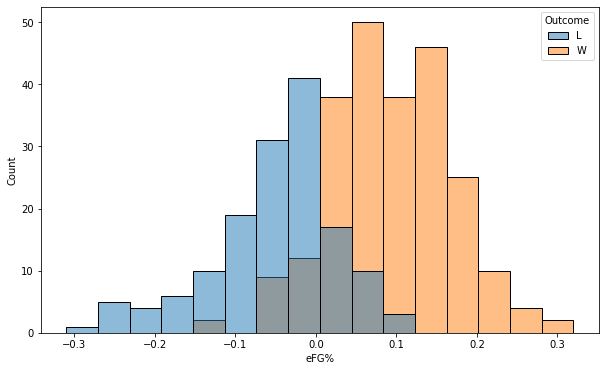

In [19]:
fig = plt.figure(figsize=(10,6))
ax = sns.histplot(data=df,x='eFG%',hue='Outcome')
fig.savefig('efg_histplot.png')

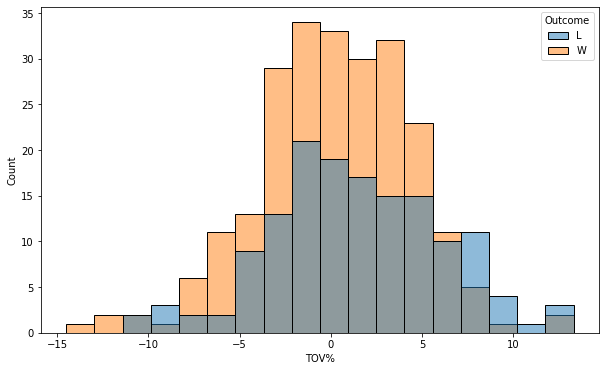

In [20]:
fig = plt.figure(figsize=(10,6))
ax = sns.histplot(data=df,x='TOV%',hue='Outcome')
fig.savefig('tov_histplot.png')

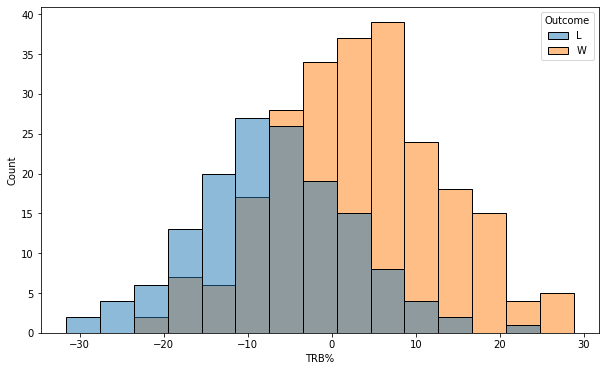

In [21]:
fig = plt.figure(figsize=(10,6))
sns.histplot(data=df,x='TRB%',hue='Outcome')
fig.savefig('trb_histplot.png')

In [22]:
df.corr()

,TS%,eFG%,3PAr,FTr,ORB%,DRB%,TRB%,AST%,STL%,BLK%,TOV%,ORtg
TS%,1.000000,0.975020,0.254779,0.086529,-0.055134,-0.055164,0.418641,0.314277,0.010124,0.315415,0.195510,0.875357
eFG%,0.975020,1.000000,0.267411,-0.057839,-0.045341,-0.045379,0.410202,0.315163,0.020746,0.333816,0.188941,0.862118
3PAr,0.254779,0.267411,1.000000,-0.061214,-0.124578,-0.124647,-0.075781,0.273330,0.028717,-0.041686,0.017644,0.235350
FTr,0.086529,-0.057839,-0.061214,1.000000,-0.106909,-0.106821,-0.014811,-0.058753,-0.025154,-0.081345,0.039236,0.011045
ORB%,-0.055134,-0.045341,-0.124578,-0.106909,1.000000,0.999999,0.841423,-0.051144,-0.060143,-0.008263,0.003229,0.232578
DRB%,-0.055164,-0.045379,-0.124647,-0.106821,0.999999,1.000000,0.841434,-0.051099,-0.060133,-0.008276,0.003240,0.232524
TRB%,0.418641,0.410202,-0.075781,-0.014811,0.841423,0.841434,1.000000,0.070717,-0.155206,0.154197,0.222529,0.561531
AST%,0.314277,0.315163,0.273330,-0.058753,-0.051144,-0.051099,0.070717,1.000000,-0.017469,0.061700,0.072110,0.280076
STL%,0.010124,0.020746,0.028717,-0.025154,-0.060143,-0.060133,-0.155206,-0.017469,1.000000,0.005679,-0.743766,0.252568
BLK%,0.315415,0.333816,-0.041686,-0.081345,-0.008263,-0.008276,0.154197,0.061700,0.005679,1.000000,0.054090,0.266257


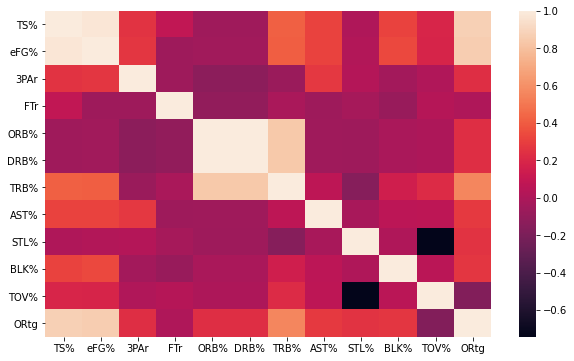

In [23]:
fig = plt.figure(figsize=(10,6))
sns.heatmap(df.corr())
fig.savefig('corr_matrx.png')

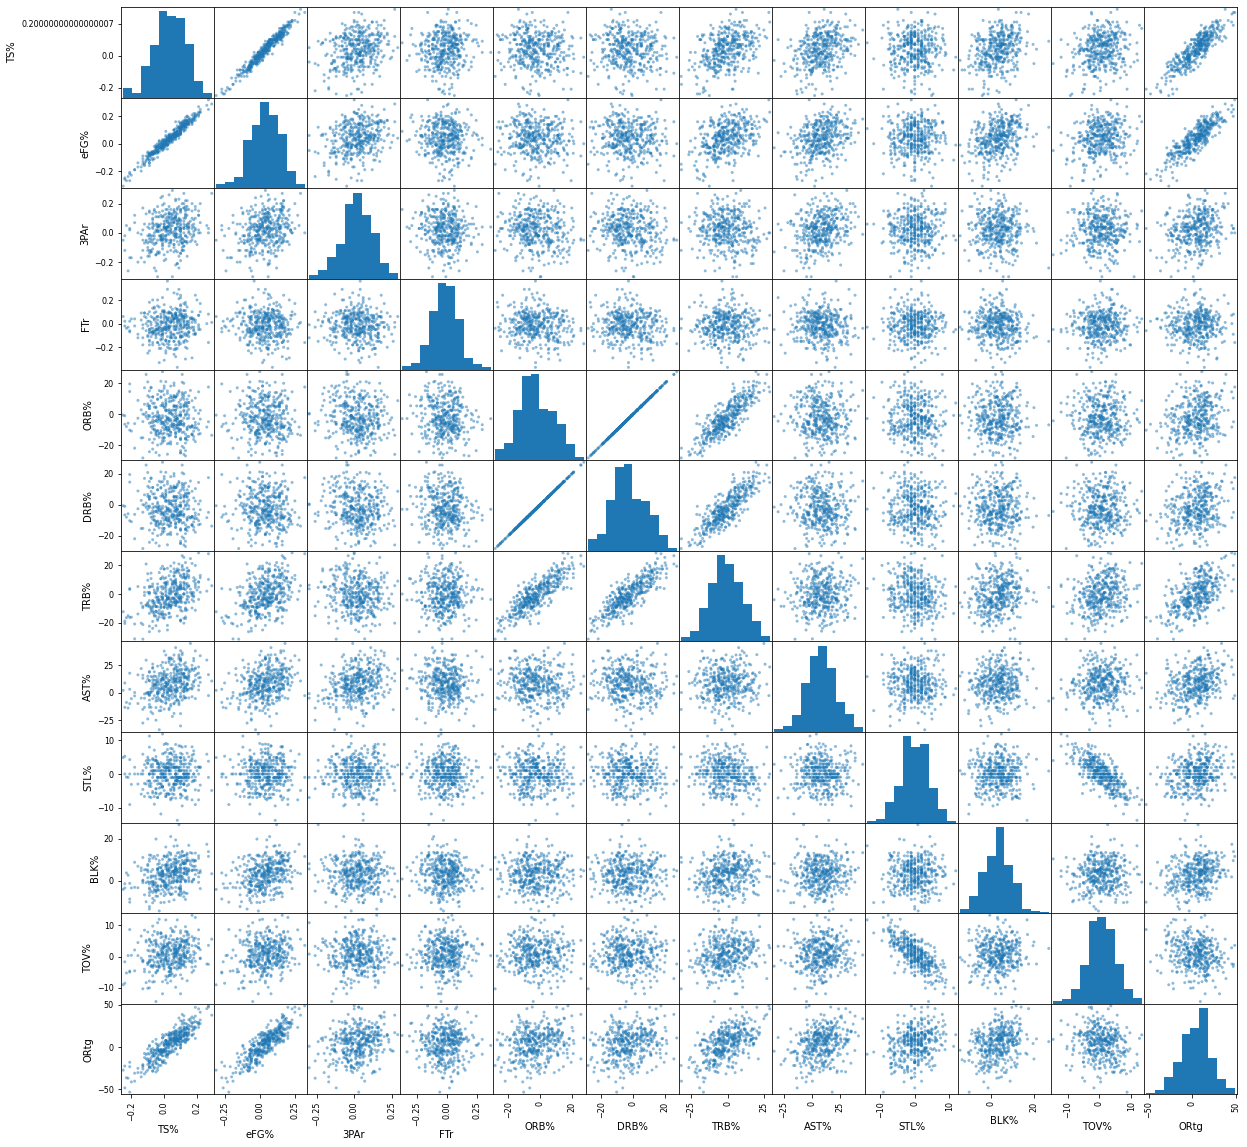

In [24]:
pd.plotting.scatter_matrix(df, figsize=(20,20));
plt.show()

## Data Preprocessing and Modeling

In [25]:
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler

In [26]:
print(len(df))
df = df.dropna()
print(len(df))

385
383


In [27]:
df['Outcome'] = df['Outcome'].apply(lambda x: True if x == 'W' else False)
df.head()

,TS%,eFG%,3PAr,FTr,ORB%,DRB%,TRB%,AST%,STL%,BLK%,TOV%,ORtg,DRtg,Outcome
0,-0.13,-0.11,-0.05,-0.12,-4.9,-4.9,-9.6,13.2,-4.6,-0.1,-1.7,-23.5,23.5,False
1,-0.23,-0.27,0.05,-0.04,-8.1,-8.1,-16.6,-8.8,-0.9,3.7,-5.3,-36.3,36.3,False
2,-0.09,-0.12,-0.02,-0.07,-0.9,-0.9,-13.6,-1.9,11.3,-1.6,-10.1,0.8,-0.8,True
3,0.13,0.14,0.05,0.16,-18.7,-18.7,-5.8,-4.7,0.0,0.0,4.6,9.8,-9.8,True
4,-0.06,-0.11,-0.02,0.09,-9.8,-9.8,-7.4,3.8,-6.7,11.6,5.1,-23.9,23.9,False


In [28]:
X = df.iloc[:, [i for i in range(len(df.columns)-1)]].values
y = df.iloc[:, len(df.columns)-1].values

In [29]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42)
print(X_train.shape, X_test.shape, y_train.shape, y_test.shape)

(268, 13) (115, 13) (268,) (115,)


In [30]:
scaler = StandardScaler()
X_train = scaler.fit_transform(X_train)
X_test = scaler.fit_transform(X_test)

In [31]:
classifier = LogisticRegression(random_state=42, solver='lbfgs')
classifier.fit(X_train, y_train)
y_pred = classifier.predict(X_test)
# y_proba = classifier.predict_proba(X_test)
classifier.score(X_test, y_test)

0.9739130434782609

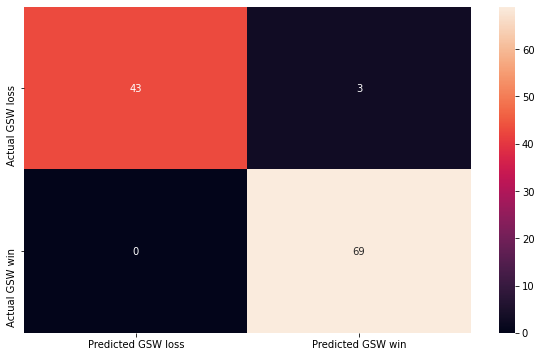

In [36]:
from sklearn.metrics import confusion_matrix
cm = confusion_matrix(y_test, y_pred)
fig = plt.figure(figsize=(10,6))
sns.heatmap(cm, annot=True, xticklabels=['Predicted GSW loss', 'Predicted GSW win'],
            yticklabels=['Actual GSW loss', 'Actual GSW win'])
fig.savefig('conf_mat.png')

In [ ]:
import sklearn.tree
from sklearn import metrics
# treeClassifier = sklearn.tree.DecisionTreeClassifier(criterion='gini')
# dtree = treeClassifier.fit(X_train, y_train)
# train_accuracy = treeClassifier.score(X_train, y_train)
# test_accuracy = treeClassifier.score(X_test, y_test)
# print("Accuracy (train): %3f" % (train_accuracy))
# print("Accuracy  (test): %3f" % (test_accuracy))

# Create Decision Tree classifer object
clf = sklearn.tree.DecisionTreeClassifier(criterion='entropy')

# Train Decision Tree Classifer
clf = clf.fit(X_train,y_train)

#Predict the response for test dataset
y_pred = clf.predict(X_test)

# Model Accuracy, how often is the classifier correct?
print("Accuracy:",metrics.accuracy_score(y_test, y_pred))


Accuracy: 0.9826086956521739


/usr/local/lib/python3.7/dist-packages/sklearn/externals/six.py:31: FutureWarning: The module is deprecated in version 0.21 and will be removed in version 0.23 since we've dropped support for Python 2.7. Please rely on the official version of six (https://pypi.org/project/six/).
  "(https://pypi.org/project/six/).", FutureWarning)


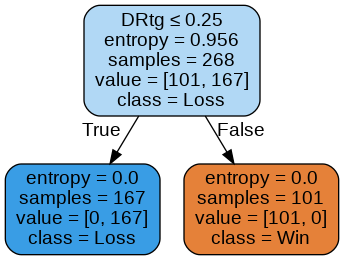

In [ ]:
from sklearn.tree import export_graphviz
from sklearn.externals.six import StringIO  
from IPython.display import Image  
import pydotplus

dot_data = StringIO()
export_graphviz(clf, out_file=dot_data,  
                filled=True, rounded=True,
                special_characters=True,feature_names = df.columns[:-1],class_names=['Win','Loss'])
graph = pydotplus.graph_from_dot_data(dot_data.getvalue())  
graph.write_png('tree.png')
Image(graph.create_png())

In [ ]:
clf.feature_importances_

array([0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 1., 0.])

In [ ]:
df[['ORtg', 'Outcome']]

,ORtg,Outcome
0,-23.5,False
1,-36.3,False
2,0.8,True
3,9.8,True
4,-23.9,False
...,...,...
380,14.3,True
381,8.5,True
382,23.2,True
383,-6.5,False


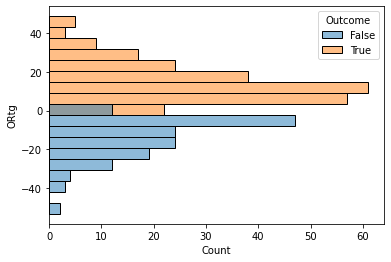

In [ ]:
fig = plt.figure()
ax = sns.histplot(data=df[['ORtg', 'Outcome']],y='ORtg',hue='Outcome')
fig.savefig('eda.png')

In [ ]:
from sklearn import svm
clf = svm.SVC()
clf = clf.fit(X_test,y_test)

#Predict the response for test dataset
y_pred = clf.predict(X_test)

# Model Accuracy, how often is the classifier correct?
print("Accuracy:",metrics.accuracy_score(y_test, y_pred))

Accuracy: 0.991304347826087
